In [1]:
import yfinance as yf

# Fetch historical data for a stock
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Fetch up to the current date (today)
stock_data = get_stock_data("AAPL", "2000-01-01", "2024-12-01")

# stock_data = get_stock_data("AAPL", "2000-01-01", "2023-01-01")


[*********************100%***********************]  1 of 1 completed


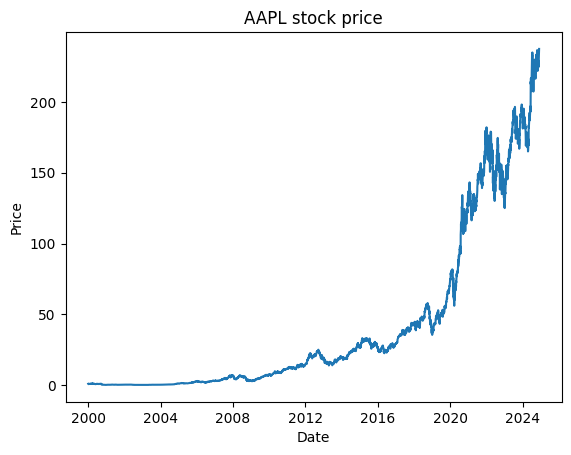

In [2]:
# Plot the stock during from 2011 to 2021

import matplotlib.pyplot as plt

# Plot the stock during from 2011-1-1 to 2021-1-1
plt.plot(stock_data['Close'])
# plt.plot(stock_data['Close'].loc['2011-01-01':'2023-12-01'])
plt.title('AAPL stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


# plt.plot(stock_data['Close'])
# plt.title('AAPL stock price')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()

In [3]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Extract 'Close' prices and scale them
prices = stock_data['Close'].values
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 15  # Use past 60 days to predict the next day
X, y = create_sequences(prices_scaled, sequence_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split the data into training and test sets randomly 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)


In [4]:
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step
        return out

# Define hyperparameters
input_size = 1  # One feature: the scaled closing price
hidden_size = 50
num_layers = 2
output_size = 1

model = StockLSTM(input_size, hidden_size, num_layers, output_size)


In [5]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device ='mps'
model.to(device)

# Train the model
epochs = 5
batch_size = 128

for epoch in range(epochs):
    for i in range(0, len(X_train) - batch_size, batch_size):
        model.train()
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Evaluate the model every 10 steps
    if (epoch+1) % 10 == 0:
        model.eval()
        for i in range(0, len(X_test) - batch_size, batch_size):
            X_batch = X_test[i:i + batch_size]
            y_batch = y_test[i:i + batch_size]
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            with torch.no_grad():
                test_outputs = model(X_batch)
                test_loss = criterion(test_outputs, y_batch)
                            
        print(f"Epoch {epoch+1}/{epochs}, Step {i+1}, Loss: {loss.item()}, Test Loss: {test_loss.item()}")
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


Epoch 1/5, Loss: 0.0003097000007983297
Epoch 2/5, Loss: 0.00014391847071237862
Epoch 3/5, Loss: 0.00014470508904196322
Epoch 4/5, Loss: 0.00015625168452970684
Epoch 5/5, Loss: 0.0001583301927894354


In [6]:
model.eval()
model.to('cpu')
with torch.no_grad():
    # test_inputs = X[]
    # the last 120 days of the X set 
    test_inputs = X
    predictions = model(test_inputs).numpy()

# Reverse scaling
predictions_unscaled = scaler.inverse_transform(predictions)


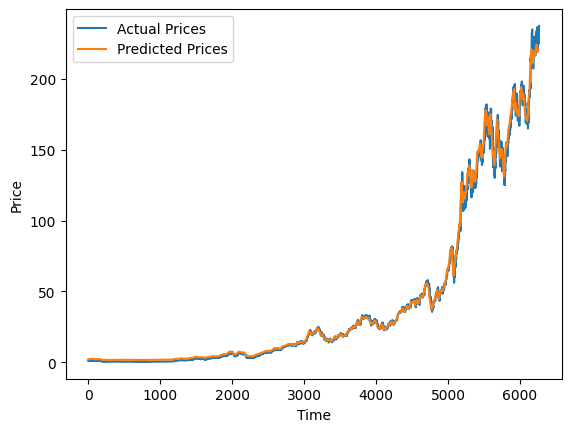

In [7]:
# plot the predicted and actual stock prices

import matplotlib.pyplot as plt

actual_prices = stock_data['Close'].values
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predictions_unscaled, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [8]:
# Save the model 
torch.save(model.state_dict(), 'stock_lstm.pth')

In [9]:
# Predict the stock price for the next day

# get the last 60 days of the stock data
last_60_days = yf.download('AAPL', period="3mo")
last_60_days = last_60_days['Close'].values[-60:]
last_60_days = scaler.transform(last_60_days.reshape(-1, 1))
last_60_days = torch.tensor(last_60_days, dtype=torch.float32).unsqueeze(0)


# last_60_days = prices_scaled[-60:]
# last_60_days = torch.tensor(last_60_days, dtype=torch.float32).unsqueeze(0)
model.eval()
with torch.no_grad():
    prediction = model(last_60_days).numpy()
        
# Reverse scaling
predicted_price = scaler.inverse_transform(prediction)[0][0]
print(f"Predicted price: {predicted_price}")


[*********************100%***********************]  1 of 1 completed

Predicted price: 257.0411376953125


[*********************100%***********************]  1 of 1 completed


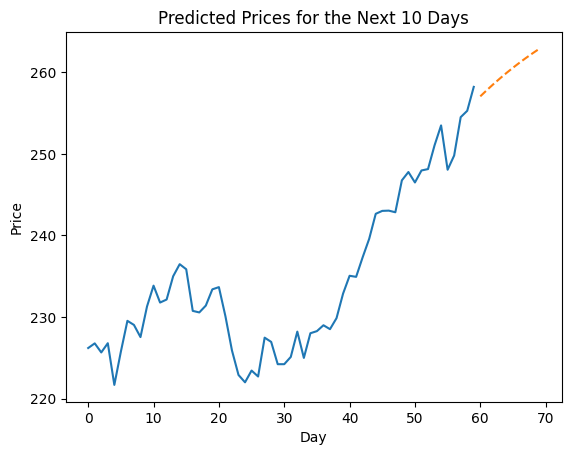

In [10]:
num_days = 10
last_60_days = yf.download('AAPL', period="3mo")
last_60_days_raw = last_60_days['Close'].values[-60:]
last_60_days = scaler.transform(last_60_days_raw.reshape(-1, 1))
predictions = []

for i in range(num_days):
    last_60_days_tensor = torch.tensor(last_60_days, dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        prediction = model(last_60_days_tensor).numpy()
        predicted_price = scaler.inverse_transform(prediction)[0][0]
        predictions.append(predicted_price)
        last_60_days = np.append(last_60_days[1:], prediction, axis=0)
        
# Reverse scaling
# predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
predicted_prices = np.array(predictions)

# Plot the predicted prices and the actual prices in the last 30 days 
# actual_prices = stock_data['Close'].values
actual_prices = last_60_days_raw

# create day indexes for the acutal and predicted prices
actual_prices_indexes = np.arange(60)
predicted_prices_indexes = np.arange(60, 60 + num_days)

plt.plot(actual_prices_indexes, actual_prices[-60:], label='Actual Prices')
plt.plot(predicted_prices_indexes, predicted_prices, label='Predicted Prices', linestyle='dashed')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title(f'Predicted Prices for the Next {num_days} Days')
plt.show()


In [11]:
# Save the model in jit format
import torch.jit
model_jit = torch.jit.script(model)
torch.jit.save(model_jit, 'stock_lstm_jit.pth')